# Template for Practical work on the Conversion of sampling frequency and STFT

In [188]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import time

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [189]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [190]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound_48kHz = os.path.join(data_path, filename) 

### **Using wave**

In [191]:
wavefile = load_sound(sound_48kHz)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [192]:
play = True
if play :
    play_sound(sound_48kHz) 

In [193]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

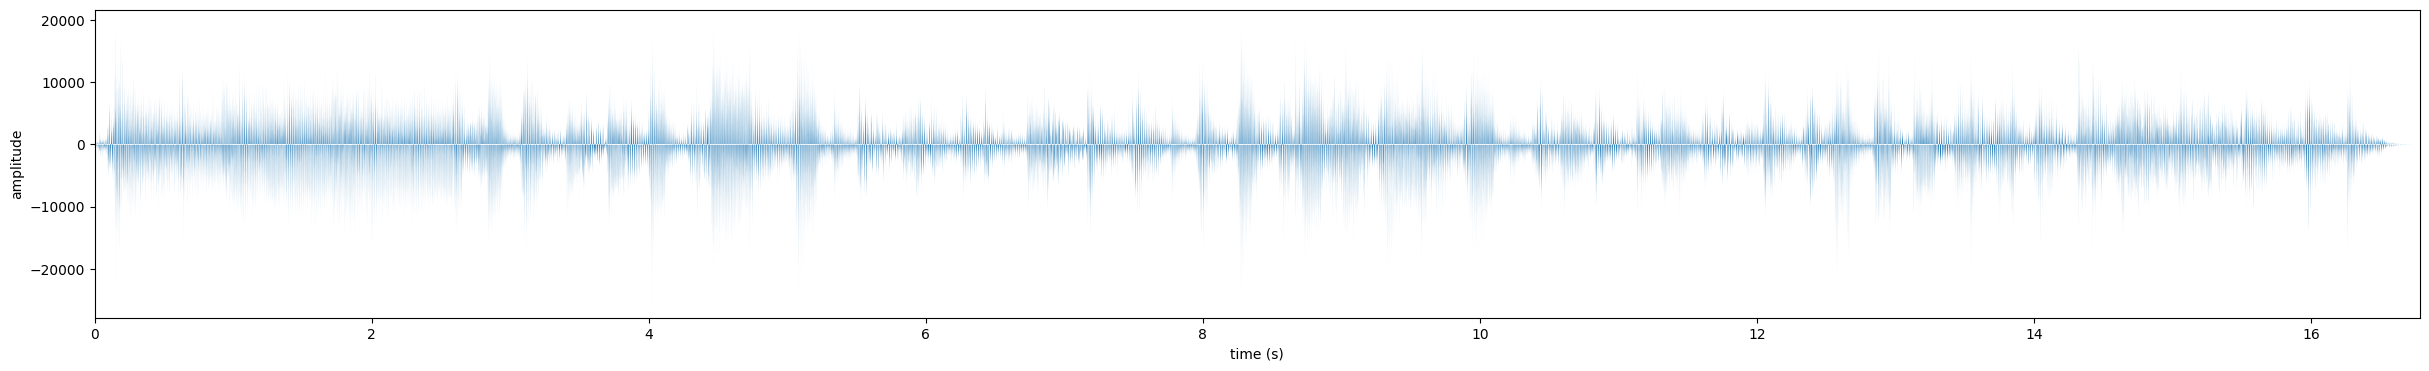

In [194]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep
plot_sound(x, times)

In [195]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

## Signal analysis with the STFT

In [196]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [197]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ...
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

## Overlap-add reconstruction

In [241]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

# Question 2 :

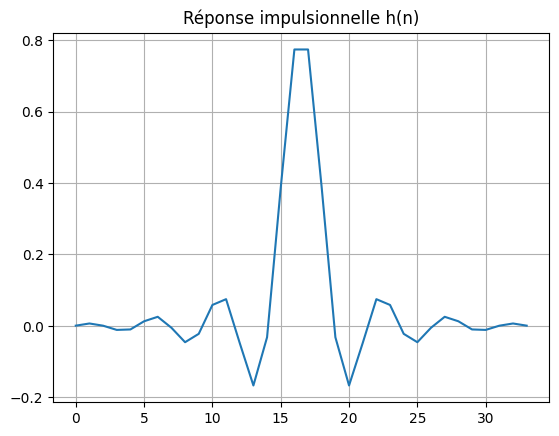

In [96]:
# h = scipy.signal.remez(even length,[0,nu_c,nu_a,.5],[L 0])
filter_order = 34
nu_c = 1/6
nu_a = 1/4
L=2
h_remez = scipy.signal.remez(filter_order, [0,nu_c,nu_a,.5], [L,0])

plt.plot([i for i in range(len(h_remez))],h_remez)
plt.title("Réponse impulsionnelle h(n)")
plt.grid()
plt.axis()
plt.show()


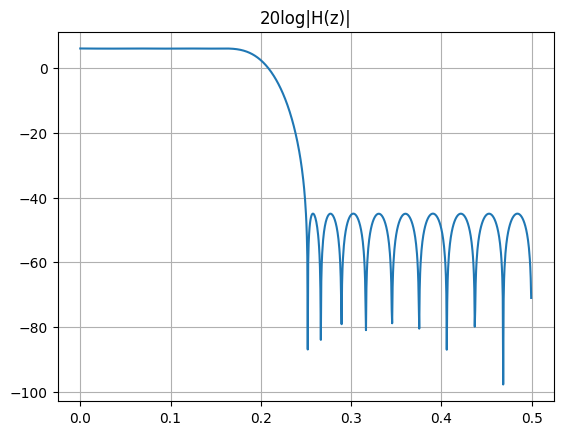

In [97]:
# On a H(exp(2i.nu.pi)) = Somme h(n)exp(-2i.pi.nu.n)

def abs_H(nu,n = filter_order):
    r = 0
    for i in range(n):
        r += h_remez[i]*np.exp(-2j*np.pi*i*nu)
    return(np.abs(r))

N = 1000 # Pas fréquentiel

X = [i/(2*N) for i in range(N)]
Y = [20*np.log10(abs_H(i/(2*N))) for i in range(N)]

plt.plot(X,Y)
plt.title("20log|H(z)|")
plt.grid()
plt.axis()
plt.show()

# Question 3 :

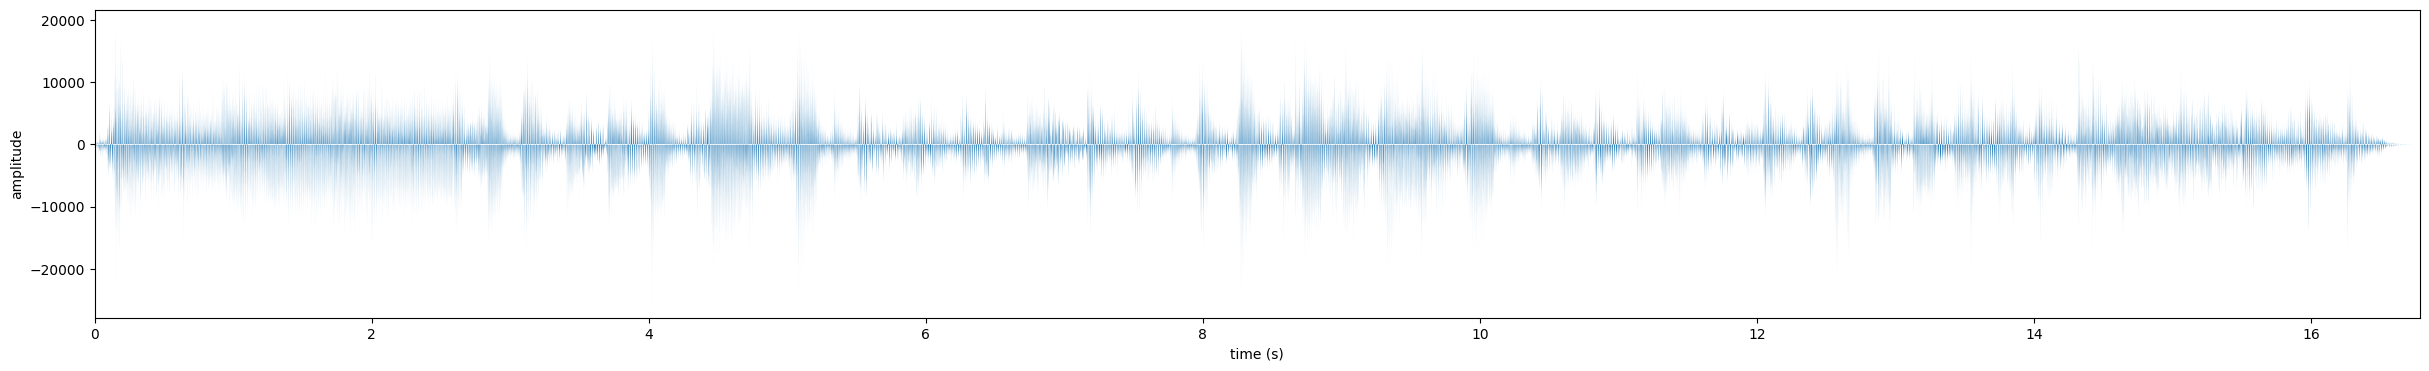

In [107]:
# Signal initial

timestep = 1/float(Fs)
times = np.arange(len(x))*timestep
plot_sound(x, times)

play = True
if play :
    play_sound(sound_48kHz) 

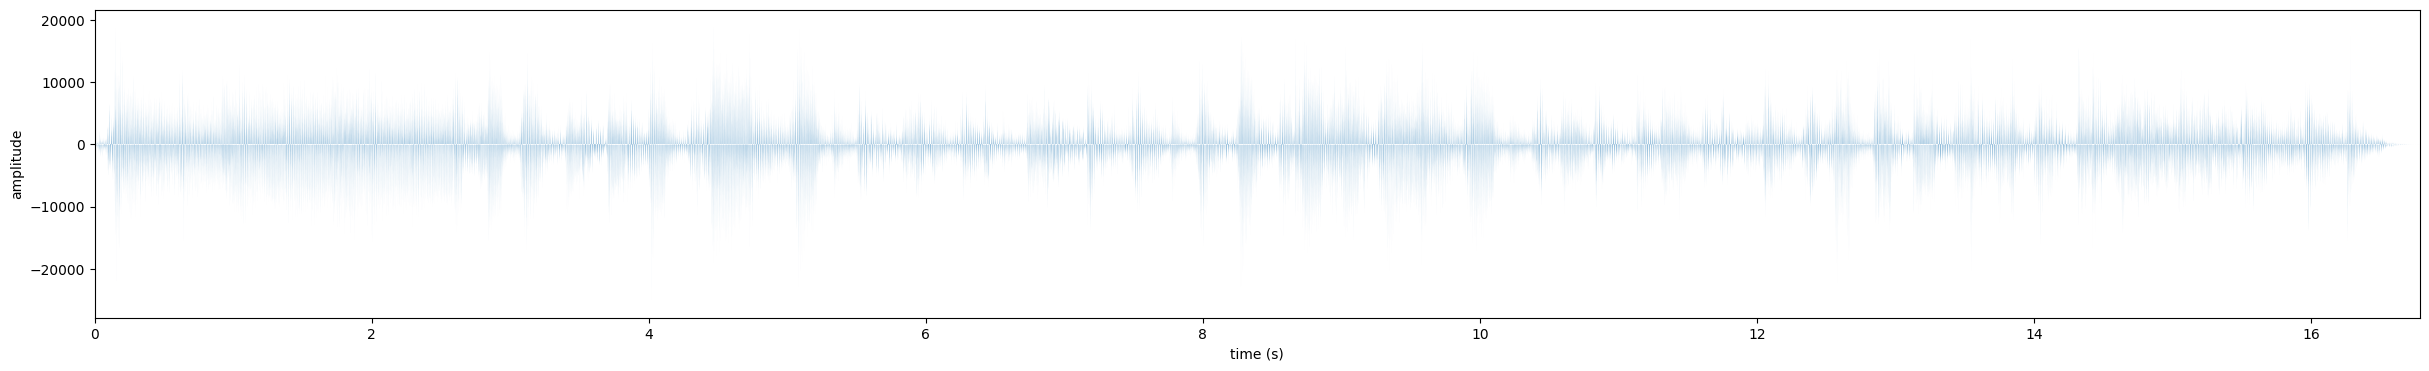

In [103]:
# Etape 1 : Sur-échantillonage, on effectue une insertion

y1 = []
for i in range (len(x)):
    y1.append(x[i])
    y1.append(0)

timestep = 1/float(2*Fs)
times = np.arange(len(y1))*timestep
plot_sound(y1, times)

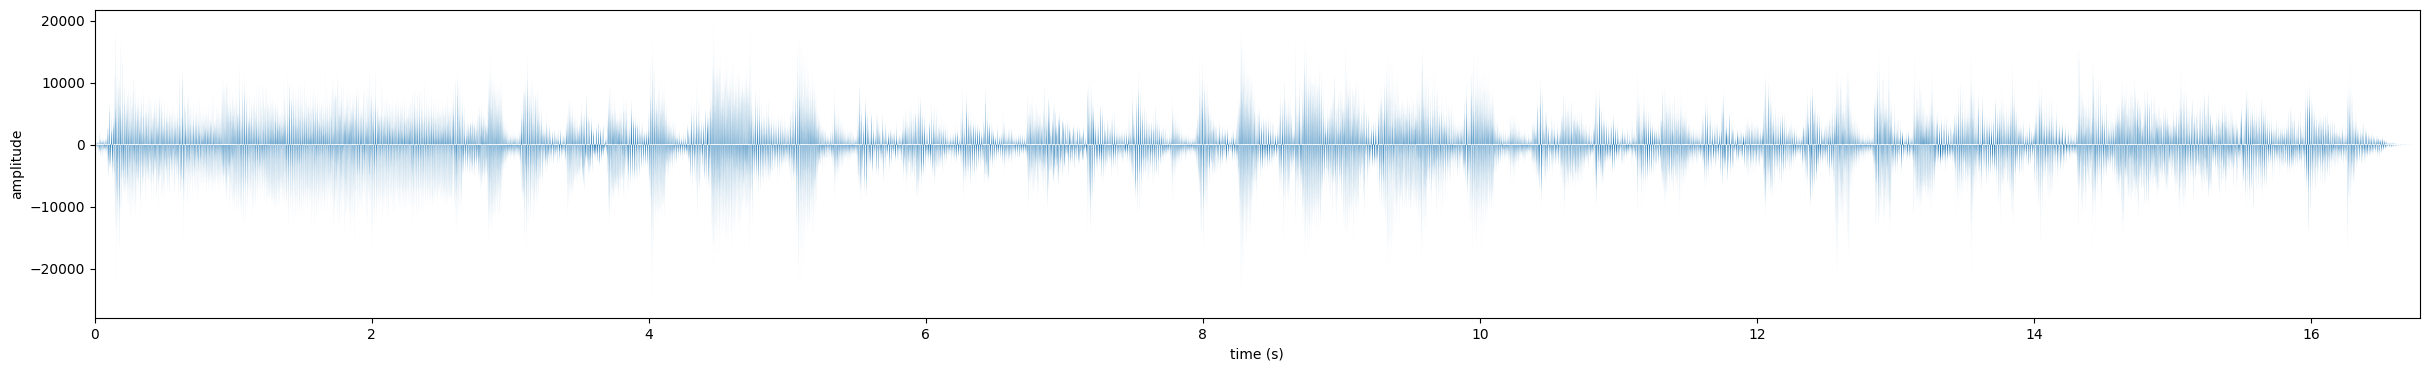

In [104]:
# Etape 2 : Application du filtre

y2 = scipy.signal.lfilter(h_remez, 1.0, y1)

timestep = 1/float(2*Fs)
times = np.arange(len(y2))*timestep
plot_sound(y2, times)

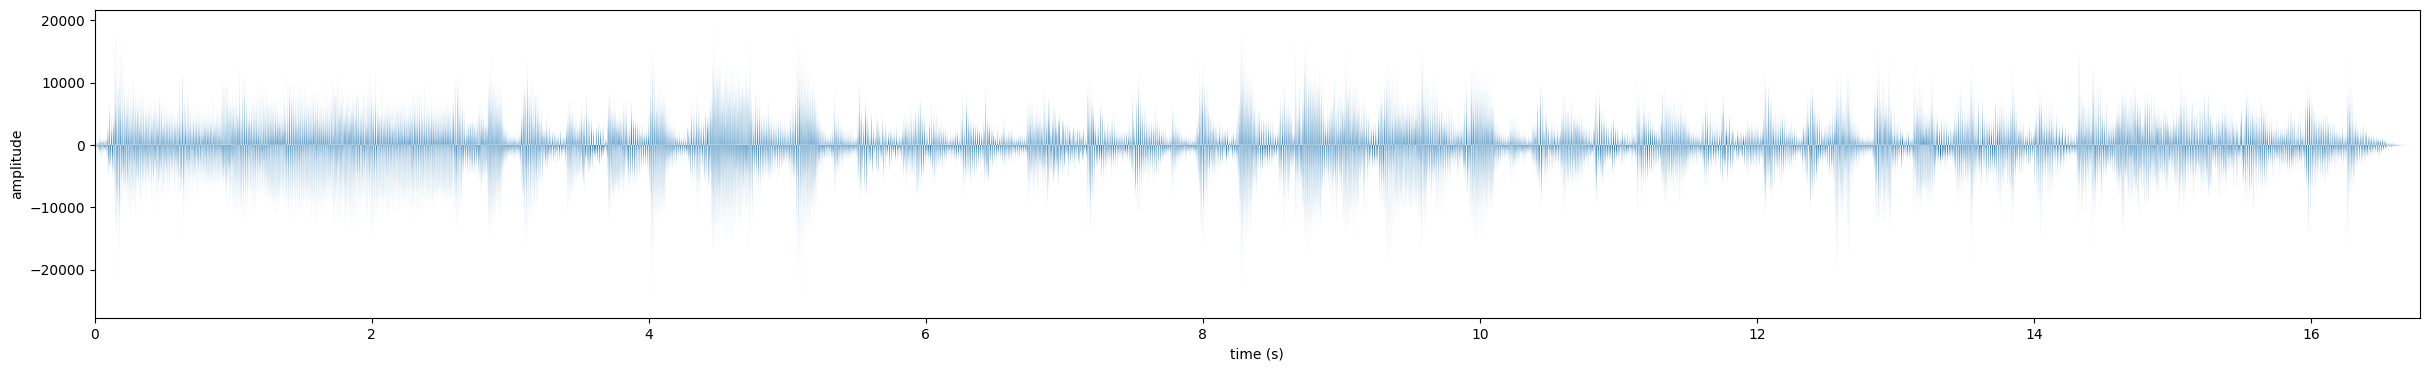

In [108]:
# Etape 3 : Sous-échantillonage, on effectue une décimation

y3 = []
for i in range(len(y2)):
    if i%3 == 0:
        y3.append(y2[i])

timestep = 1/float(2*Fs/3)
times = np.arange(len(y3))*timestep
plot_sound(y3, times)


In [199]:
# On écrit le signal dans un nouveau fichier wav

write('caravan_32kHz.wav', 32000, np.array(y3, dtype=np.int16)) # Fs = 32kHz fréquence d'échantillonage finale

# On l'écoute

data_path = os.getcwd()
filename = 'caravan_32khz.wav'
sound_32kHz = os.path.join(data_path, filename) 
play = True
if play:
    play_sound(sound_32kHz)

# Observations de la question 3 :

On observe que le signal rééchantillonné semble inchangé à l'écoute, mais que sa taille passe de 1574 Ko (pour le fichier initial) à 525 Ko pour le fichier rééchantillonné.

# Question 5 :

Pour la méthode non optimisée, le rééchantillonnage prend 0.6899378299713135
Pour la méthode optimisée, le rééchantillonnage prend 2.8805747032165527


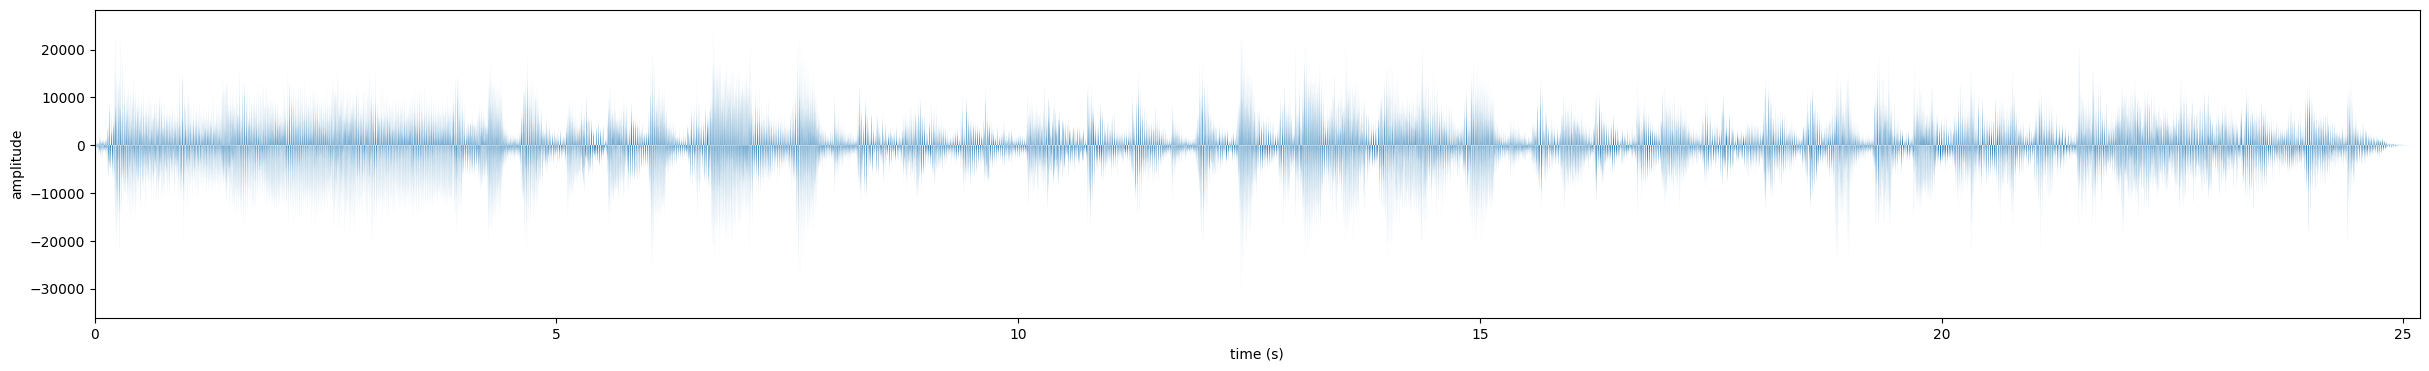

In [210]:
# Rééchantillonnage non optimisé

debut = time.time()
y1 = []
for i in range (len(x)):
    y1.append(x[i])
    y1.append(0)
y2 = scipy.signal.lfilter(h_remez, 1.0, y1)
y3 = []
for i in range(len(y2)):
    if i%3 == 0:
        y3.append(y2[i])
delta = time.time() - debut
print(f"Pour la méthode non optimisée, le rééchantillonnage prend {delta}")

# Rééchantillonage optimisé

def shift(u,k=1): # Décalage de k indice la suite u
    L = [0]*k
    return(np.concatenate((L,u[:-k])))

def decimation(u,k): # Décimation du signal u d'un rapport k
    v = []
    for i in range (len(u)):
        if i%k == 0:
            v.append(u[i])
    return(v)

def insertion(u,k): # Décimation du signal u d'un rapport k
    v = []
    for i in range (len(u)):
        v.append(u[i])
        for j in range(k):
            v.append(0)
    return(v)

"""
debut = time.time()

# Etape 1 :
y1 = []
for i in range (len(x)):
    y1.append(x[i])
    y1.append(0)

y1 = shift(insertion(scipy.signal.lfilter(decimation(shift(h_remez),2), 1.0, x),2)) # Branche du haut
y2 = insertion(scipy.signal.lfilter(decimation(h_remez,2), 1.0, x),2) # Branche du bas

y3 = np.array(y1) + np.array(y2) # Premier noeud

# Etape 2 :

y4 = scipy.signal.lfilter(decimation(h_remez,3),1.0,decimation(y3,3)) # Branche du haut après le noeud central
y5 = scipy.signal.lfilter(decimation(shift(h_remez),3),1.0,decimation(shift(y3),3)) # Branche du milieu après le noeud central
y6 = scipy.signal.lfilter(decimation(shift(h_remez,2),3),1.0,decimation(shift(y3,2),3)) # Branche du bas après le noeud central

y7 = np.array(y4) + np.array(y5) + np.array(y6)

delta = time.time() - debut

print(f"Pour la méthode optimisée, le rééchantillonnage prend {delta}")

timestep = 1/float(2*Fs/3)
times = np.arange(len(y7))*timestep
plot_sound(y7, times)
"""

# Partie 2 : STFT

# Question 1 :

La fenêtre de Hann de longueur $N_w$ est définie par :

$\forall n \leq N_{w}$,   w[n] = 0.5 [1 - $\cos(\frac{2\pi n}{N_w})$] = $\sin(\frac{\pi n}{N_w})^2$  
   

$\forall n > N_{w}$,   w[n] = 0 

Largeur du lobe à -3dB en fonction de Nw :
Valeur théorique : 0.002
Valeur obtenue graphiquement : 0.0016666666666666668


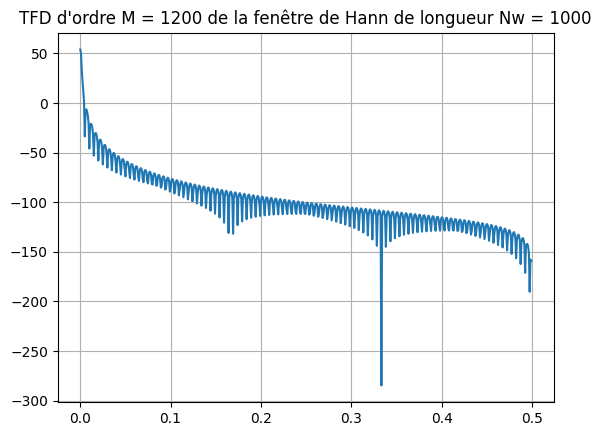

In [239]:
Nw = 1000 # Longueur de la fenêtre de Hann
M = 1200 # Ordre de la TFD


w = np.hanning(Nw) # Définition de la fenetre de Hann
hann = np.pad(w,(0,M-Nw)) # On ajoute des 0 à la fin pour obtenir une fenêtre définie sur {1,...,M}
TFD_hann = np.fft.fft(hann,M) # Transformée de Fourier discrète avec M ordre de la TFD

X = [i/M for i in range (M//2)]
Y = [20*np.log10(abs(TFD_hann[i])) for i in range(M//2)]

# Pour trouver la largeur du lobe principal, on regarde la valeur maximale (en 0), on retire 3 dB, et on double la fréquence correspondante
seuil = Y[0] - 3  # Niveau à -3 dB

for i in range(len(X)) :
    if Y[i] < Y[0] - 3:
        bande = 2*X[i]
        break

print("Largeur du lobe à -3dB en fonction de Nw :")
print(f"Valeur théorique : {2/Nw}")
print(f"Valeur obtenue graphiquement : {bande}")

plt.plot(X,Y)
plt.title(f"TFD d'ordre M = {M} de la fenêtre de Hann de longueur Nw = {Nw}")
plt.grid()
plt.axis()
plt.show()